Ref: https://www.quora.com/Why-exactly-do-neural-networks-need-multiple-layers-deep-learning-Please-provide-a-real-example

* You need only 3 layers to represent any mapping from input to output. This is called the universal approximation theorem, which states that a feedforward network with a linear output layer and at least one hiddenlayer with certain activation functions (sigmoid and ReLUs included) is able to approximate any function that maps from any finite-dimensional discrete space (which includes basically everything that you could potentially use a CPU or GPU for) to another.

* So an easy 3 Layer MLP can easily represent any mapping that you want your neural network to learn given that it has enough units in the hidden layer. 

* Now the catch is that ability to represent does not mean ability to learn. Furthermore the required size for the hidden layer may be too large to actually make the network useful. The reason multiple layers are used is that it has been shown empirically that deep networks usually require a much smaller (often exponentially smaller) size to approximate the same function and often generalize better to uneen data than shallow networks. Further having a deep network uses the general belief among machine learning scientists that the function that the network is supposed to transform, say handwritten digit recognition, is made up of different sub-functions. So the first hidden layer might recognize bars and edges, the second recognizes strokes etc. 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import os
import time
import numpy as np
import pandas as pd

from os import listdir
from io import BytesIO
import requests

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,utils
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from scipy import stats
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import PIL
from PIL import Image

import seaborn as sns
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [3]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
DATA_DIR = 'data/caps and shoes extended/'
IMAGE_SIZE = (28,28)

In [5]:
def convert_img_to_data(image):
    data = np.asarray(image)
    gs_image = image.convert(mode='L')
    gs_data = np.asarray(gs_image)
    gs_image.thumbnail(IMAGE_SIZE, Image.ANTIALIAS)
    gs_resized = gs_image.resize(IMAGE_SIZE,Image.ANTIALIAS)
    gs_resized_data = np.asarray(gs_resized)
    reshaped_gs_data = gs_resized_data.reshape(IMAGE_SIZE[0]*IMAGE_SIZE[1])
    return reshaped_gs_data

def convert_images_from_dir(dir_path):
    image_data = []
    
    for filename in listdir(dir_path):
        image = Image.open(dir_path +os.sep + filename)
        reshaped_gs_data = convert_img_to_data(image)
        image_data.append(reshaped_gs_data)
    
    return image_data

def load_from_dir(dir_path, labels):
    label_data = []
    image_data = []
    for label in labels:
        data_from_dir = convert_images_from_dir(dir_path + label)
        labels_for_data = [label for i in range(len(data_from_dir))]
        image_data += data_from_dir
        label_data += labels_for_data
    
    print('Found %d images belonging to %d classes' % (len(image_data),  len(labels)))
    return (np.array(image_data),np.array(label_data))

def load_img_data(data_dir):
    train_dir = DATA_DIR + 'train/'
    validation_dir = DATA_DIR + 'val/'
    test_dir = DATA_DIR + 'test/'
    
    if (os.path.isdir(train_dir) and os.path.isdir(validation_dir) and os.path.isdir(test_dir)) :
        labels = [subdirname.name for subdirname in os.scandir(train_dir) if subdirname.is_dir()] 
        
        train_data = load_from_dir(train_dir,labels)
        validation_data = load_from_dir(validation_dir,labels)
        test_data = load_from_dir(test_dir,labels)
        
    return train_data, validation_data, test_data     

def url_to_image(img_url):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    return img

def plot_images(ims, figsize=(24,12), rows=1, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        
        plt.imshow(ims[i].reshape(IMAGE_SIZE[0],IMAGE_SIZE[1]), cmap="gray")

In [6]:
train_data, validation_data, test_data = load_img_data(DATA_DIR)
X_train, y_train = train_data
X_val, y_val = validation_data
X_test, y_test = test_data

Found 2301 images belonging to 2 classes
Found 678 images belonging to 2 classes
Found 327 images belonging to 2 classes


In [7]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [8]:
print('X_train shape : %s' % str(X_train.shape))
print('y_train shape : %s' % str(y_train.shape))
print('X_val shape : %s' % str(X_val.shape))
print('y_val shape : %s' % str(y_val.shape))
print('X_test shape : %s' % str(X_test.shape))
print('y_test shape : %s' % str(y_test.shape))

X_train shape : (2301, 784)
y_train shape : (2301,)
X_val shape : (678, 784)
y_val shape : (678,)
X_test shape : (327, 784)
y_test shape : (327,)


In [9]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)
y_train = utils.to_categorical(y_train)
y_val = utils.to_categorical(y_val)
y_test = utils.to_categorical(y_test)

In [10]:
print('y_train shape : %s' % str(y_train.shape))
print('y_val shape : %s' % str(y_val.shape))
print('y_test shape : %s' % str(y_test.shape))

y_train shape : (2301, 2)
y_val shape : (678, 2)
y_test shape : (327, 2)


#### Find number of neurons required for single layer network

In [11]:
def define_singlelayer_model_architecture(no_of_neurons=32):
    model = models.Sequential()
    model.add(Dense(no_of_neurons, activation='relu', input_shape=(IMAGE_SIZE[0]*IMAGE_SIZE[1],)))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
no_of_neurons = [2**i for i in range(1,10)] + [512 + 48*i for i in range(1,5)]
ITER = 5

log_list = []
for neurons in no_of_neurons:
    print('No. of neurons : %d' % neurons)
    training_time_list = []
    test_accuracy_list = []
    for iter_count in range(ITER):
        model = define_singlelayer_model_architecture(neurons)
        start_time = time.time()
        model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=60, batch_size=32, verbose=0, shuffle=True)
        training_time = time.time() - start_time
        training_time_list.append(training_time)
        test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
        test_accuracy_list.append(test_accuracy)
    
    avg_training_time = np.mean(training_time_list)
    avg_test_accuracy = np.mean(test_accuracy_list)
    std_test_accuracy = np.std(test_accuracy_list)
    
    log_list.append({'neurons': neurons, 'avg training time(s)' : avg_training_time, 'params' : model.count_params(),
                     'avg test accuracy' : avg_test_accuracy, 'test accuracy std dev': std_test_accuracy})
    
    print('Avg training time : %.3f s' % avg_training_time)
    print('Avg test accuracy : %.4f +- %.2f' % (avg_test_accuracy, std_test_accuracy))
    print('Total parameters : %d' % model.count_params())
    print('-'*120)

No. of neurons : 2


W0811 09:59:10.849250 140572932007744 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Avg training time : 6.308 s
Avg test accuracy : 0.7780 +- 0.03
Total parameters : 1576
------------------------------------------------------------------------------------------------------------------------
No. of neurons : 4
Avg training time : 5.710 s
Avg test accuracy : 0.7804 +- 0.02
Total parameters : 3150
------------------------------------------------------------------------------------------------------------------------
No. of neurons : 8
Avg training time : 5.909 s
Avg test accuracy : 0.7896 +- 0.02
Total parameters : 6298
------------------------------------------------------------------------------------------------------------------------
No. of neurons : 16
Avg training time : 5.820 s
Avg test accuracy : 0.7951 +- 0.01
Total parameters : 12594
------------------------------------------------------------------------------------------------------------------------
No. of neurons : 32
Avg training time : 5.846 s
Avg test accuracy : 0.8024 +- 0.02
Total parameters : 25186
-

In [13]:
neuron_accuracy_data = pd.DataFrame(log_list)
neuron_accuracy_data

,neurons,avg training time(s),params,avg test accuracy,test accuracy std dev
0,2,6.308466,1576,0.777982,0.025410
1,4,5.710437,3150,0.780428,0.018389
2,8,5.908894,6298,0.789602,0.015400
3,16,5.819639,12594,0.795107,0.010050
4,32,5.846182,25186,0.802446,0.016366
5,64,5.841318,50370,0.811621,0.037183
6,128,5.840157,100738,0.816514,0.010234
7,256,5.776351,201474,0.809786,0.026406
8,512,5.971612,402946,0.806728,0.031390
9,560,5.994695,440722,0.825076,0.022255


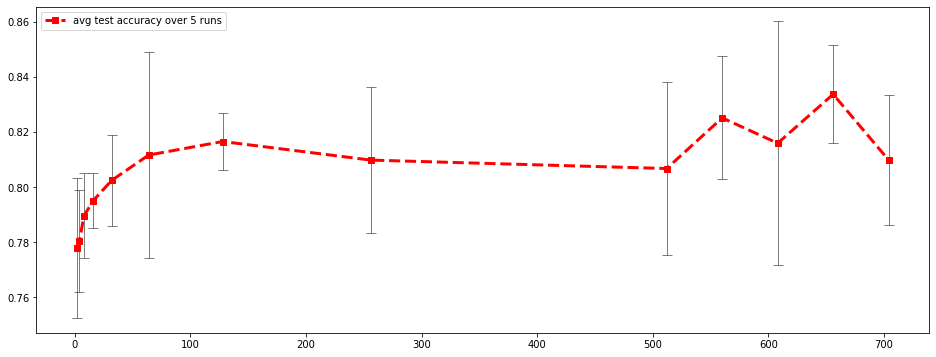

In [18]:
plt.figure(num=None, figsize=(16, 6))
line,caps,bars=plt.errorbar(neuron_accuracy_data['neurons'],neuron_accuracy_data['avg test accuracy'],
                            yerr=neuron_accuracy_data['test accuracy std dev'], fmt="rs--", linewidth=3, elinewidth=0.5, ecolor='k', capsize=5, 
                            capthick=0.5)

plt.setp(line,label="avg test accuracy over 5 runs")
plt.legend(numpoints=1, loc=('upper left'))
#plt.xlim((0.5,4.5))
plt.show()

### Define multiple multilayer architectures

In [19]:
def define_multilayer_model_architecture_128_32_8():
    model = models.Sequential()
    model.add(Dense(128, activation='relu', input_shape=(IMAGE_SIZE[0]*IMAGE_SIZE[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [20]:
def define_multilayer_model_architecture_64_32_16():
    model = models.Sequential()
    model.add(Dense(64, activation='relu', input_shape=(IMAGE_SIZE[0]*IMAGE_SIZE[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [21]:
def define_multilayer_model_architecture_32_16_8():
    model = models.Sequential()
    model.add(Dense(32, activation='relu', input_shape=(IMAGE_SIZE[0]*IMAGE_SIZE[1],)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [32]:
def define_multilayer_model_architecture_16_8():
    model = models.Sequential()
    model.add(Dense(16, activation='relu', input_shape=(IMAGE_SIZE[0]*IMAGE_SIZE[1],)))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [22]:
def define_multilayer_model_architecture_64_8():
    model = models.Sequential()
    model.add(Dense(64, activation='relu', input_shape=(IMAGE_SIZE[0]*IMAGE_SIZE[1],)))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [24]:
def define_multilayer_model_architecture_32_8():
    model = models.Sequential()
    model.add(Dense(32, activation='relu', input_shape=(IMAGE_SIZE[0]*IMAGE_SIZE[1],)))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [40]:
model_dict = {'128_32_8' : define_multilayer_model_architecture_128_32_8(),
              '64_32_16' : define_multilayer_model_architecture_64_32_16(),
              '32_16_8' : define_multilayer_model_architecture_32_16_8(),
              '16_8' : define_multilayer_model_architecture_16_8(),
              '64_8' : define_multilayer_model_architecture_64_8(),
              '32_8' : define_multilayer_model_architecture_32_8()}

epochs_list = [60,100,125,140]

ITER = 10

model_log_list = []
for model_name in model_dict.keys():
    for epochs_no in epochs_list:
        
        print('model name : %s #epochs : %d' % (model_name,epochs_no))
        
        training_time_list = []
        test_accuracy_list = []

        for iter_count in range(ITER):
            start_time = time.time()
            model = model_dict[model_name]
            model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=epochs_no, batch_size=32, verbose=0, shuffle=True)
            training_time = time.time() - start_time
            training_time_list.append(training_time)
            test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
            test_accuracy_list.append(test_accuracy)
    
        avg_training_time = np.mean(training_time_list)
        avg_test_accuracy = np.mean(test_accuracy_list)
        std_test_accuracy = np.std(test_accuracy_list)

        model_log_list.append({'model_name': model_name, 'epochs' : epochs_no, 'avg training time(s)' : avg_training_time, 
                               'params' : model.count_params(), 'avg test accuracy' : avg_test_accuracy, 
                               'test accuracy std dev': std_test_accuracy})
    
        print('Avg training time : %.3f s' % avg_training_time)
        print('Avg test accuracy : %.4f +- %.2f' % (avg_test_accuracy, std_test_accuracy))
        print('Total parameters : %d' % model.count_params())
        print('-'*120)

model name : 128_32_8 epochs : 60
Avg training time : 6.210 s
Avg test accuracy : 0.8358 +- 0.02
Total parameters : 104890
------------------------------------------------------------------------------------------------------------------------
model name : 128_32_8 epochs : 100
Avg training time : 9.879 s
Avg test accuracy : 0.8550 +- 0.01
Total parameters : 104890
------------------------------------------------------------------------------------------------------------------------
model name : 128_32_8 epochs : 125
Avg training time : 12.345 s
Avg test accuracy : 0.8590 +- 0.00
Total parameters : 104890
------------------------------------------------------------------------------------------------------------------------
model name : 128_32_8 epochs : 140
Avg training time : 13.952 s
Avg test accuracy : 0.8590 +- 0.00
Total parameters : 104890
------------------------------------------------------------------------------------------------------------------------
model name : 64_32_

In [41]:
model_architecture_data = pd.DataFrame(model_log_list)
model_architecture_data

,model_name,epochs,avg training time(s),params,avg test accuracy,test accuracy std dev
0,128_32_8,60,6.209644,104890,0.835780,0.024159
1,128_32_8,100,9.879109,104890,0.855046,0.008778
2,128_32_8,125,12.344663,104890,0.859021,0.003976
3,128_32_8,140,13.952109,104890,0.859021,0.002540
4,64_32_16,60,5.981765,52882,0.850153,0.019438
5,64_32_16,100,10.015040,52882,0.859327,0.006700
6,64_32_16,125,12.414095,52882,0.870948,0.004494
7,64_32_16,140,13.850933,52882,0.868807,0.000917
8,32_16_8,60,6.050140,25802,0.833028,0.023537
9,32_16_8,100,9.844343,25802,0.841284,0.012493


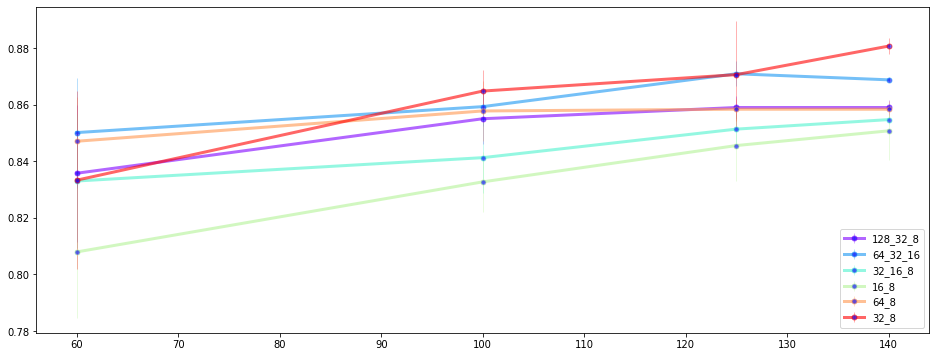

In [69]:
plt.figure(num=None, figsize=(16, 6))
color = iter(plt.cm.rainbow(np.linspace(0,1,len(model_dict.keys()))))

for model_name in model_dict.keys():
    plt.errorbar('epochs', 'avg test accuracy', yerr='test accuracy std dev', data=model_architecture_data[model_architecture_data['model_name'] == model_name], 
              marker='o', markerfacecolor='blue', markersize=5, color=next(color), linewidth=3, elinewidth=0.5, label=model_name, alpha=0.6)
plt.legend(loc=('lower right'))